In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [2]:
def eval_metrics(tn, fp, fn, tp):
    total = tn + fp + fn + tp
    accuracy = (tn + tp) / total
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (accuracy, precision, recall)

## Custom Classifier

Pretrained classifiers like TextBlob, Vader etc. work most of the time. However, when the text is related to specific fields that are not common, we may be required to train custom classifiers.

Steps for custom classifier training:
1. Generate text embeddings
2. Train classification model on the top of them
3. Evaluate model performance

# 01 - Load Data

In [3]:
# data source: Kaggle - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
df_original = pd.read_csv("../Data/IMDB Dataset.csv")
# Sample 1K each positive and negative reviews
df = (
    df_original.groupby("sentiment")
    .sample(n=1000, random_state=0)
    .reset_index(drop=True)
)
df["sentiment"].value_counts()

sentiment
negative    1000
positive    1000
Name: count, dtype: int64

In [4]:
df.head()

,review,sentiment
0,"I am wanting to make a ""Holmes with Doors"" pun...",negative
1,This had high intellectual pretensions.The mai...,negative
2,"Tim Robbins is oddly benign here, cast as a ga...",negative
3,"Poorly acted, poorly written and poorly direct...",negative
4,While this isn't one of Miss Davies' very wors...,negative


In [5]:
# Clean the text

In [6]:
# Download stopwords from NLTK
nltk.download("punkt_tab")
nltk.download("stopwords")
print(stopwords.words("english"))
stop_words = set(stopwords.words("english"))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/dsrivallabha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsrivallabha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
ps = PorterStemmer()

def stopwordremoval(inp_text):
    customlist = [">", "<", "/", ".", ",", "br"]
    word_tokens = word_tokenize(inp_text)
    sw = [ps.stem(w) for w in word_tokens]
    # by making it lower case
    fs1 = [w for w in sw if not w.lower() in stop_words]
    fs = [w for w in fs1 if w not in customlist]
    return " ".join(fs)

In [8]:
ps = PorterStemmer()


def stopwordremoval(inp_text):

    # break words into tokens
    word_tokens = word_tokenize(inp_text.lower())

    # remove stop words
    fs1 = [w for w in word_tokens if not w in stop_words]

    # remove custom list
    customlist = [">", "<", "/", ".", ",", "br", ")", "(", "!", "--"]
    fs = [w for w in fs1 if w not in customlist]

    # stem the words
    sw = [ps.stem(w) for w in fs]

    return ' '.join(sw)

In [9]:
# Tokenizing and stop word removal
inp_text = (
    """This is a sample sentence, showing off </ br> the stop words filtration."""
)
word_tokens = stopwordremoval(inp_text)
print("word tokens", word_tokens)

word tokens sampl sentenc show stop word filtrat


In [10]:
df["filtered_words"] = df["review"].apply(lambda x: stopwordremoval(x))

In [11]:
df.head()

,review,sentiment,filtered_words
0,"I am wanting to make a ""Holmes with Doors"" pun...",negative,want make `` holm door '' pun ca n't quit stri...
1,This had high intellectual pretensions.The mai...,negative,high intellectu pretensions.th main lead inten...
2,"Tim Robbins is oddly benign here, cast as a ga...",negative,tim robbin oddli benign cast garag mechan 1950...
3,"Poorly acted, poorly written and poorly direct...",negative,poorli act poorli written poorli direct specia...
4,While this isn't one of Miss Davies' very wors...,negative,n't one miss davi ' worst film pretti bad 's s...


## 02 - Generate Embeddings

## 02-01 Simple TF IDF

In [12]:
# Limit features for simplicity
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df=0.6, min_df=10)  
X = tfidf_vectorizer.fit_transform(df["filtered_words"])
y = df["sentiment"]

In [13]:
(X[1].toarray().shape)

(1, 1000)

In [14]:
(X.toarray().shape)

(2000, 1000)

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model Training (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [16]:
# Model Evaluation
y_pred = model.predict(X_test)

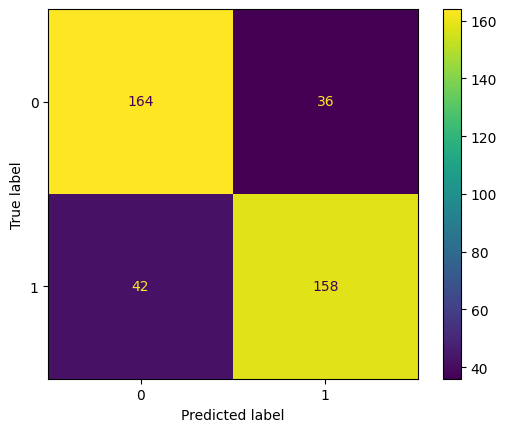

In [17]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# 02-02 Use BERT embeddings

In [18]:
import torch
from transformers import BertModel, BertTokenizer

In [19]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # we only need embeddings (no fine-tuning)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [20]:
# Function to get BERT sentence embedding (CLS token)
def get_bert_embedding(text):
    # Tokenize and encode
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, max_length=64, padding="max_length"
    )

    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # CLS token embedding at index 0
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

In [21]:
# Apply embedding function
df["vector"] = df["review"].apply(get_bert_embedding)

In [22]:
# Convert list of vectors into feature matrix
X = np.vstack(df["vector"].values)
y = df["sentiment"].values

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [25]:
# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.72


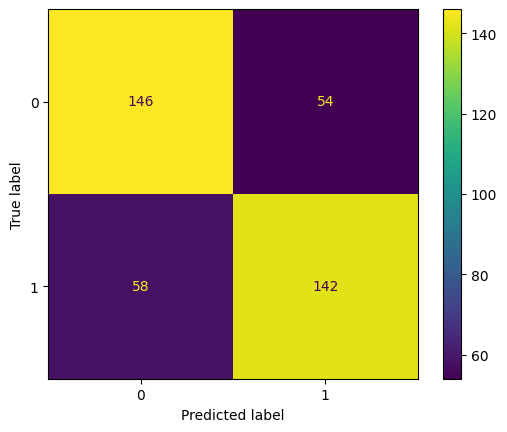

In [26]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()